# Cat VS Dog classification
By using the Keras library to train a deep convolution neural network

dataset: https://www.kaggle.com/c/dogs-vs-cats/data

It contains 25000 images, 12500 for cat and other half for a dog.

In [19]:
# Import libraries
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras import models, callbacks
from keras.preprocessing import image
from keras.applications import vgg16
from keras.layers import Flatten, Dropout, Dense

In [16]:
# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %.4f'%history.history['acc'][-1])
    print('Last validation accuracy: %.4f'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result for Dog&Cat
def evaluation_report_dogcat(model, test_generator):
  
  # Calculate result
  result = model.evaluate(test_generator, verbose=False)

  # Predict
  pred_class = (model.predict(test_generator) >= 0.5).astype(np.int)

  cm = confusion_matrix(test_generator.labels, pred_class, labels=[0, 1])
  cr = classification_report(test_generator.labels, pred_class, labels=[0, 1],
                             target_names=['Cat', 'Dog'])
  # Plot confusion matrix
  plt.figure(figsize=(6,6))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Greens', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Cat', 'Dog'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Cat', 'Dog'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion matrix')
  plt.show()

  print('Classification Report:\n', cr)
  print('Loss: %s Accuracy: %s' %(result[0], result[1]))

  return pred_class

### Part1: Load data

In [2]:
%%capture
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

In [3]:
image_dir = Path('/content/Cat_Dog_data')

##### Create dataframe of paths and labels

In [4]:
trainPaths = list(image_dir.glob(r'**/train/**/*.*.jpg'))
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], trainPaths))

trainPaths = pd.Series(trainPaths, name='Filepath').astype(str)
train_labels = pd.Series(train_labels, name='Label')

train_df = pd.concat([trainPaths, train_labels], axis=1)

In [5]:
testPaths = list(image_dir.glob(r'**/test/**/*.*.jpg'))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], testPaths))

testPaths = pd.Series(testPaths, name='Filepath').astype(str)
test_labels = pd.Series(test_labels, name='Label')

test_df = pd.concat([testPaths, test_labels], axis=1)

##### Train/validation split

In [6]:
train_df, val_df = train_test_split(train_df, train_size=0.8, 
                                    shuffle=True, random_state=42)

### Part2: Preprocessing

In [7]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNEL = 3
BATCH_SIZE = 32

##### Define a generator for training and test sets

In [8]:
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=False,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         zoom_range=0.2,
                                         shear_range=0.2)

test_datagen = image.ImageDataGenerator(rescale=1./255)

##### Create an iterator object

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
val_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 18000 validated image filenames belonging to 2 classes.
Found 4500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Part3: Build a convolution neural network model

In [10]:
# Using VGG16 as a pre-trained model
vgg = vgg16.VGG16(weights='imagenet', include_top=False,
                  input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNEL))
vgg.trainable = False
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
# Add output layer to the vgg
model = models.Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output (Dense)              (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


### Part4: Training

In [12]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(train_generator, validation_data=val_generator,
                    epochs=10, callbacks=[early_stop])

Epoch 1/10
563/563 [==============================] - 337s 580ms/step - loss: 0.3349 - acc: 0.8586 - val_loss: 0.2350 - val_acc: 0.9002
Epoch 2/10
563/563 [==============================] - 311s 552ms/step - loss: 0.2567 - acc: 0.8885 - val_loss: 0.2428 - val_acc: 0.8931
Epoch 3/10
563/563 [==============================] - 309s 549ms/step - loss: 0.2283 - acc: 0.9021 - val_loss: 0.2251 - val_acc: 0.9000
Epoch 4/10
563/563 [==============================] - 309s 549ms/step - loss: 0.2186 - acc: 0.9070 - val_loss: 0.2250 - val_acc: 0.9024
Epoch 5/10
563/563 [==============================] - 309s 550ms/step - loss: 0.2091 - acc: 0.9098 - val_loss: 0.2010 - val_acc: 0.9153
Epoch 6/10
563/563 [==============================] - 308s 547ms/step - loss: 0.2009 - acc: 0.9148 - val_loss: 0.2067 - val_acc: 0.9129
Epoch 7/10
563/563 [==============================] - 311s 553ms/step - loss: 0.1989 - acc: 0.9143 - val_loss: 0.2188 - val_acc: 0.9076


Last train accuracy: 0.9143
Last validation accuracy: 0.9076


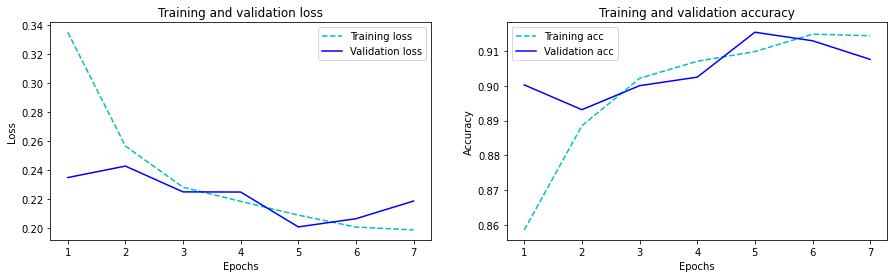

In [20]:
show_result(history)

### Part5: Model evaluation

79/79 [==============================] - 14s 177ms/step


<ipython-input-16-0f45f2bc3847>:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_class = (model.predict(test_generator) >= 0.5).astype(np.int)


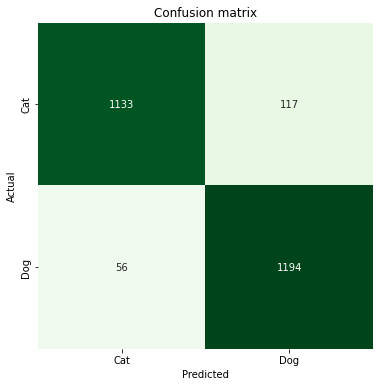

Classification Report:
               precision    recall  f1-score   support

         Cat       0.95      0.91      0.93      1250
         Dog       0.91      0.96      0.93      1250

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500

Loss: 0.1820339858531952 Accuracy: 0.9308000206947327


In [21]:
pred_class = evaluation_report_dogcat(model, test_generator)